# Collateral Shortfall Monitoring

For more context and definitions around collateral shortfall monitoring, [check out our article on atoti.io](https://www.atoti.io/rapid-collateral-modelling-and-simulation-with-atoti/).

### Introduction

In this notebook, we will showcase how quickly a dashboard can be put together for a simplified use case of Collateral Shortfall monitoring with atoti libraries.  
  
Collateral is a form of credit risk mitigation where an asset is accepted as security for extending a loan.  
Market value of a collateral changes over time and lender has to accomodate for it. As such, depending on the amount of risk associated, a percentage of what is known as haircut is applied to the asset's market value. This gives the value of the collateral that can be used for loan, also known as collateral value.   
  
Collateral Shortfall occurs when the collateral value goes below the cash out value. That meant that the value of collateral is less than what it is expected to be, due to a variety of factors such as market fluctuations, contracts enforceability etc. 

We will be creating a multi-dimension data cube and derive the various measures such as market value, collateral value after haircut, cash out value over account and thereafter, the Collateral shortfall for the accounts. 

Leveraging on the data cube and atoti's data visualization, we will put together dashboards that reflects collateral status of accounts. Cherry on top, we will perform some *What if Analysis* to demonstrate the impact on Collateral in the below scenarios:  

- Haircut simulation where there is a consumption slowdown in the Consumer Cyclical sector in Italy and France
- Technology slump where price value for the sector dipped by 30%
- Cash out simulation where cash out increase by 10%

In [1]:
import datetime

import atoti as tt
import numpy as np
import pandas as pd

from predictive_data import predictive

Welcome to atoti 0.4.0!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


In [2]:
# tell atoti to load the database containing the UI dashboards
config = tt.config.create_config(metadata_db="./metadata.db")

# a session has to be created for atoti
session = tt.create_session(config=config)

### Data loading
A session is used to read data of formats csv, parquet, pandas dataframe, numpy and spark.   
Refer to https://docs.atoti.io/0.4.0/tutorial/07-Data-sources.html
   
#### Loading csv

In [3]:
asset_positions_store = session.read_csv(
    "s3://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_positions.csv",
    keys=["Account", "Asset_Code"],
    store_name="asset_positions_store",
)

In [4]:
# use store.head(n) preview the first n rows loaded into the store where needed
# likewise, you can use store.columns to preview the columns in the store
# or store.shape to see the number of rows and columns loaded into the store
asset_positions_store.head(5)

Quantity
Account           Asset_Code          
Niel              CAP.PA      100000.0
                  SAN.PA      100000.0
Musk              ENI.PA      100000.0
                  ENGI.PA     100000.0
Bezos & MacKenzie AC.PA       100000.0

### Loading csv via pandas before session loads pandas dataframe   
Being able to load pandas dataframe gives us the flexibility to manipulate dataframe before loading them or later on when we do simulations.

In [5]:
assets_prices_df = pd.read_csv(
    "http://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_prices.csv"
)

# for predictive simulation
assets_prices_df["Date"] = assets_prices_df["Date"].astype("datetime64[ns]")
assets_prices_df["Year_Month"] = assets_prices_df["Date"].dt.strftime("%Y-%m")

assets_prices = session.read_pandas(
    assets_prices_df, keys=["Asset_Code", "Date"], store_name="assets_prices_store"
)

# by default, it will display the first 5 rows of the store
assets_prices.head()

Price Year_Month
Asset_Code Date                             
BNP.PA     2020-03-10  100.553603    2020-03
           2020-03-09   99.605505    2020-03
           2020-03-08   98.393106    2020-03
           2020-03-07   98.996166    2020-03
           2020-03-06  100.594698    2020-03

In [6]:
loans_positions_df = pd.read_csv(
    "http://data.atoti.io/notebooks/collateral-shortfall-monitoring/loans_positions.csv"
)

In [7]:
loans_positions_store = session.read_pandas(
    loans_positions_df, keys=["Account"], store_name="loans_positions_store"
)

In [8]:
loans_positions_store.head()

,Cash_Out
Account,
Bezos & MacKenzie,16000000.0
Buffet,54000000.0
Daniel Ek,9000000.0
Gates & Melinda,17000000.0
Musk,9000000.0


### Loading parquet

In [9]:
# atoti supports loading directly from a parquet file.
# However an issue in 0.3.1 prevents from pulling parquet file from s3 protocol directly. Using pandas meanwhile.
assets_attributes = pd.read_parquet(
    "https://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_attributes.parquet"
)
assets_store = session.read_pandas(
    assets_attributes, keys=["Asset_Code"], store_name="assets_store"
)
assets_store.head()

,Sector,Country,Haircut
Asset_Code,,,
BNP.PA,Financial Services,France,0.1
CA.PA,Consumer Defensive,France,0.1
AC.PA,Consumer Cyclical,France,0.1
ENGI.PA,Utilities,France,0.1
CAP.PA,Technology,France,0.1


### Joining datastore

In [10]:
asset_positions_store.join(assets_store, mapping={"Asset_Code": "Asset_Code"})

In [11]:
asset_positions_store.join(loans_positions_store, mapping={"Account": "Account"})

In [12]:
asset_positions_store.join(assets_prices, mapping={"Asset_Code": "Asset_Code"})

### Cube creation

In [13]:
asset_positions_cube = session.create_cube(
    asset_positions_store, "Collateral_Management"
)

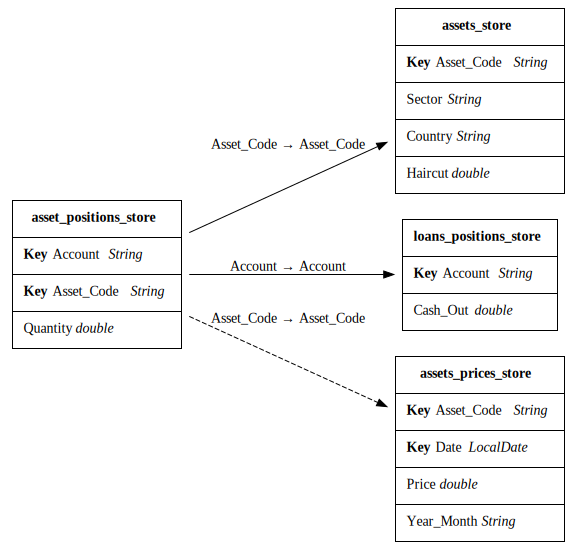

In [14]:
asset_positions_cube.schema

### Quick analysis with cube.visualize

In [16]:
# we can perform drill-down to different hierarchies in a pivot table
asset_positions_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

In [17]:
# we can look at the price.VALUE across Date, further split the charts by Asset_Code
asset_positions_cube.visualize("times-series")

Install and enable the atoti JupyterLab extension to see this widget.

In [19]:
# give a meaningful title to the visualization. This helps to reconcile the objective of the visual and also could be the title of
# the widget when visual is published
asset_positions_cube.visualize("haircut-value")

Install and enable the atoti JupyterLab extension to see this widget.

In [21]:
asset_positions_cube.visualize("explore-dataset-using-pivot-table")

Install and enable the atoti JupyterLab extension to see this widget.

### Cube structure
During cube creation, numeric values are automatically created as measures. Non numeric values are automatically translated to levels under hierarchy of the same name. This can be configured differently. Refer to https://docs.atoti.io/0.4.0/lib/atoti.html#atoti.session.Session.create_cube.

In [22]:
m = asset_positions_cube.measures
h = asset_positions_cube.hierarchies
lvl = asset_positions_cube.levels

Before we proceed with the data aggregation aspects, let's inspect the hierarchies created

In [23]:
h

Hierarchies()

We are going to set the hierarchy *Date* as a slicing hierarchy. A slicing hierarchy will not aggregate the data on all its members.  
This means that we always view a subset of the cube by one date by default, which is usually what is needed.

In [24]:
h["Date"].slicing = True

In [25]:
m

Measures()

### Creating new measures  
From the data we have, we can derive the following:   
$Market Value = Price \times Quantity$  
$Collateral Value = Market Value \times (1 - Haircut)$   
  
The above measures are aggregated over the Account and Asset Code levels in order to compute the Collateral Shortfall at account level:  
$Collateral Shortfall = Collateral Value - Cash Out$   
Where Cash Out is also aggregated at account level           

In [26]:
m["Market Value"] = tt.agg.sum(
    m["Price.VALUE"] * m["Quantity.SUM"],
    scope=tt.scope.origin(lvl["Account"], lvl["Asset_Code"]),
)

In [27]:
m["Collateral Value"] = tt.agg.sum(
    m["Price.VALUE"] * m["Quantity.SUM"] * (1 - m["Haircut.VALUE"]),
    scope=tt.scope.origin(lvl["Account"], lvl["Asset_Code"]),
)

In [28]:
m["Cash Out"] = tt.agg.sum(m["Cash_Out.VALUE"], scope=tt.scope.origin(lvl["Account"]))

In [29]:
m["Collateral Shortfall"] = m["Collateral Value"] - m["Cash Out"]

In [30]:
m

Measures()

### Monitoring Collateral Shortfall  
We created a pivot table for with the Collateral Shortfall, Market Value, Cash Out and Collateral Value for Accounts.  
Negative Collateral Shortfall are highlighted in red. Feel free to click on the `>` to drill-down to other hierarchies such as Sector to account for the shortfall. 

In [32]:
asset_positions_cube.visualize("Collateral Shortfall")

Install and enable the atoti JupyterLab extension to see this widget.

In view of all accounts, using a Gauge chart will show us that we are not yet in shortfall and how far we are from it.   
The red marker shows the total Market value, which is the maximum threshold before shortfall will occur.

In [34]:
asset_positions_cube.visualize("total-cash-out")

Install and enable the atoti JupyterLab extension to see this widget.

### Total Cash out Bank wide  
  
We can use a Tree map to visualize the asset concentration. A well diversified portfolio will help to reduce the collateral risks.

In [36]:
asset_positions_cube.visualize("Asset_Concentration")

Install and enable the atoti JupyterLab extension to see this widget.

## atoti UI and Dashboard creation
Until now, we have created a few visualizations. We can right-click on the visuals to publish them as widgets.
These widgets can then be used to build a dashboard.  

<img src="http://data.atoti.io/notebooks/collateral-shortfall-monitoring/collateral_dashboard.gif" alt="collateral_dashboard" style="zoom:40%;" />

In [37]:
session.url + "/#/dashboard/f6c"

'http://localhost:63789/#/dashboard/f6c'

Click on the URL above to view the dashboard that was prepared. We can use the quick filter to select an account for viewing.  
We can also do a right-click drillthrough to investigate the underlying data.  
  
To play with the UI and explore the data, [you can have a look at our UI documentation here](https://www.activeviam.com/activeui/documentation/index.html).

## Simulations
Now that we have basic monitoring on Collateral Shortfall, we can do some simulations in the data cube without having to duplicate or reload data.  
  
### Setup Haircut Simulation
We are going to perform a Haircut simulation where there is a consumption slowdown in the Consumer Cyclical sector in Italy and France.  
In this use case, we will replace the value of haircut for the mentioned sector and country to see its downstream impact on the Collaterals.

In [38]:
# we have to do a setup_simulation, where scenarios added to this simulation will follow the same pattern of simulation
# E.g. same levels and method on measure, in this case, replace Haircut
# we set the base_scenario_name to "Current Market Condition" - this is the original set of data currently in the cube
haircut_simulation = asset_positions_cube.setup_simulation(
    "Haircut Simulation",
    levels=[lvl["Sector"], lvl["Country"]],
    replace=[m["Haircut.VALUE"]],
    base_scenario="Current Market Condition",
)
haircut_simulation

Simulation(_name='Haircut Simulation', _levels=[Level(_name='Sector', _column_name='Sector', _data_type='string', _hierarchy=Hierarchy(_name='Sector', _levels={'Sector': ...}, _dimension='Hierarchies', _slicing=False), _comparator=None), Level(_name='Country', _column_name='Country', _data_type='string', _hierarchy=Hierarchy(_name='Country', _levels={'Country': ...}, _dimension='Hierarchies', _slicing=False), _comparator=None)], _multiply=[], _replace=[NamedMeasure(_name='Haircut.VALUE', _folder=None, _formatter='DOUBLE[#,###.00]', _visible=True)], _add=[], _base_scenario='Current Market Condition')

In [39]:
# create a new scenario with a meaningful name
consumption_slowdown = haircut_simulation.scenarios["Consumption Slowdown"]

In [40]:
# parameters in the sequence of levels defined in the "per" during setup_simulation
consumption_slowdown += ("Consumer Cyclical", "Italy", 0.20)
consumption_slowdown += ("Consumer Cyclical", "France", 0.15)

#### Analysing the impact of Consumption Slowdown  
  
We will create a chart showing Collateral Shortfall against Account, split by *Haircut Simulation* - the Measure Simulation we just created.  
We will be able to see that with a slowdown in Italy and France, *Gates & Melinda* will go into shortfall and the shortfall amount for *Buffet* increased dramatically.   
The Consumer Cyclical  in Italy and France does not impact *Daniel EK*, *Musk* and *Niel*.

In [42]:
asset_positions_cube.visualize("Consumption Slowdown")

Install and enable the atoti JupyterLab extension to see this widget.

With a pivot table, we can easily see the amount of collateral generated by the *Consumer Cyclical* sector in Italy and France.

In [44]:
asset_positions_cube.visualize("Consumption Slowdown by Sector")

Install and enable the atoti JupyterLab extension to see this widget.

### Market Value Simulation
We are going to create a new set of simulation where technology sector goes into a slump and price value for the sector dipped by 30%.  
We see that while the levels we will be simulating are the same as the previous simulation, now instead of replacing the Haircut value, we will multiply the Price value by 0.7.  

In [45]:
market_value_simulation = asset_positions_cube.setup_simulation(
    "Market Value Simulation",
    levels=[lvl["Sector"], lvl["Country"]],
    multiply=[m["Price.VALUE"]],
    base_scenario="Current Market Condition",
)

In [46]:
tech_bubble = market_value_simulation.scenarios["Tech Bubble ?"]

In [47]:
# we are going to simulate a slump technology in all countries, therefore we pass the value `*` for country level
tech_bubble += ("Technology", None, 0.70)

#### Analysing the impact of Technology slump  
  
As before, we plot a chart of Collateral Shortfall against Account. However, we are going to do a split by the *Market Simulation* that we just created.  
We will see the technology giant such as *Gates & Melinda* suffering greatly as their shortfall goes beyond 1.5 million.  
Likewise Buffet with 1/6 of assets in Technology also suffered.

In [49]:
asset_positions_cube.visualize("Tech Bubble ?")

Install and enable the atoti JupyterLab extension to see this widget.

As we drill-in further to simulation for *Buffet* vs *Gates*, we see that *Buffet* has greater shortfall as they have a higher Cash Out value for the Technology sector than *Gates* while their market value was the same. 

In [51]:
asset_positions_cube.visualize("Market Simulation - Gates vs Buffet")

Install and enable the atoti JupyterLab extension to see this widget.

### Setup Cash out Simulation

The previous simulations we have done are called Measure simulations.  
There is a different kind of simulation known as Source simulation.  

In Measure simulations, we modify the value of the measures in scenarios of the simulations without duplicating data.  
Source simulation on the other hand, is a simulation created by loading a new source of modified data to the cube.  

Let's modify the loans_positions_df that was previously loaded into the cube, and increase its Cash_Out value by 10%.  
For our *Cash out simulation*, we shall load this modified dataframe directly into the store as a scenario.

In [52]:
loans_positions_df["Cash_Out"] = loans_positions_df["Cash_Out"].apply(
    lambda x: (1 + 0.1) * x
)

In [53]:
loans_positions_df

,Account,Cash_Out
0,Bezos & MacKenzie,17600000.0
1,Buffet,59400000.0
2,Daniel Ek,9900000.0
3,Gates & Melinda,18700000.0
4,Musk,9900000.0
5,Niel,15400000.0


In [54]:
# In Source Simulation, we do not perform simulation_setup. We just load it to the store as scenarios.
cashout_simulation = loans_positions_store.scenarios["Cash out Increase"].load_pandas(
    loans_positions_df, truncate=True
)

#### Analysing the impact of increase in Cash Out

While cash out increases but collateral value remains the same, we see that the shortfall situation is worsen.

In [56]:
asset_positions_cube.visualize("Cash out Increase")

Install and enable the atoti JupyterLab extension to see this widget.

#### Activate Source Simulation

In atoti UI, we have 2 kinds of widgets for simulations:  

- Measure Simulations
  - enable user to update, create new or duplicate simulations
  - available upon setup_simulation
- Source Simulations
  - enable users to upload their modified source files via UI as simulation
  - have to explicitly enable to be accessible from UI
  
Next we will enable source simulation.

In [57]:
loans_positions_store.source_simulation_enabled = True

Once we have enabled the source simulation, we can proceed to integrate the Source Simulations widget in our dashboard.  
<img src="http://data.atoti.io/notebooks/collateral-shortfall-monitoring/source_simulation.gif" alt="source_simulation" style="zoom:40%;" />  
  
To play with the source simulation, click on the link on the next output cell.

In [58]:
session.url + "/#/dashboard/78f"

'http://localhost:63789/#/dashboard/78f'

### Predictive Simulation  

Most banks would have their own predictive engine to do the market forecast.  
Using the past year data and a simplified predictive model, we will generate the pricing forecast and visualize the future collateral shortfall.

In [59]:
recent_date = assets_prices_df["Date"].max().strftime("%Y-%m-%d")
asset_last_day_df = assets_prices_df.loc[assets_prices_df["Date"] == recent_date]

In [60]:
asset_last_day_df

,Asset_Code,Date,Price,Year_Month
0,BNP.PA,2020-03-10,100.553603,2020-03
360,CA.PA,2020-03-10,100.107521,2020-03
720,AC.PA,2020-03-10,101.496249,2020-03
1080,ENGI.PA,2020-03-10,98.608115,2020-03
1440,CAP.PA,2020-03-10,104.166550,2020-03
1800,SAN.PA,2020-03-10,101.452488,2020-03
2160,G.MI,2020-03-10,97.576423,2020-03
2520,RACE.MI,2020-03-10,101.949971,2020-03
2880,TIT.MI,2020-03-10,98.498659,2020-03
3240,JUVE.MI,2020-03-10,101.320637,2020-03


We generate the price value for the next 3 months from the last data date.

In [61]:
predictive_3_months = predictive.generate_prices(
    asset_last_day_df, pd.to_datetime(recent_date), 90, 1, 0
)
predictive_3_months.tail(10)

,Asset_Code,Date,Price,Year_Month
1058,ENI.MI,2020-05-29,100.161177,2020-05
1059,ENI.MI,2020-05-30,102.554077,2020-05
1060,ENI.MI,2020-05-31,104.404900,2020-05
1061,ENI.MI,2020-06-01,96.773379,2020-06
1062,ENI.MI,2020-06-02,100.486419,2020-06
1063,ENI.MI,2020-06-03,102.910266,2020-06
1064,ENI.MI,2020-06-04,100.027068,2020-06
1065,ENI.MI,2020-06-05,102.266270,2020-06
1066,ENI.MI,2020-06-06,98.327826,2020-06
1067,ENI.MI,2020-06-07,101.965592,2020-06


In [62]:
predictive_simulation = assets_prices.scenarios["3 months forecast"].load_pandas(
    predictive_3_months, truncate=True
)

In [64]:
asset_positions_cube.visualize("Predictive Collateral shortfall")

Install and enable the atoti JupyterLab extension to see this widget.

### Combining Source and Measure Simulation

Now that we have the predictive data for the next 3 months, we can do the apply the following simulations:
- Source simulation showing gradual price drop over the next 3 months  
- Consumption slowdown scenario in the Haircut simulation created previously  

Below we manipulate the predictive data such that there is a gradual 5% drop in Price value each month for the next 3 months. 

In [65]:
predictive_price_drop = predictive_3_months.copy()
predictive_price_drop["Price"] = np.where(
    (predictive_price_drop.Year_Month == "2020-04"),
    predictive_price_drop.Price * 0.95,
    predictive_price_drop.Price,
)
predictive_price_drop["Price"] = np.where(
    (predictive_price_drop.Year_Month == "2020-05"),
    predictive_price_drop.Price * 0.9,
    predictive_price_drop.Price,
)
predictive_price_drop["Price"] = np.where(
    (predictive_price_drop.Year_Month == "2020-06"),
    predictive_price_drop.Price * 0.85,
    predictive_price_drop.Price,
)
predictive_price_drop.head(10)

,Asset_Code,Date,Price,Year_Month
0,BNP.PA,2020-03-10,100.553603,2020-03
360,CA.PA,2020-03-10,100.107521,2020-03
720,AC.PA,2020-03-10,101.496249,2020-03
1080,ENGI.PA,2020-03-10,98.608115,2020-03
1440,CAP.PA,2020-03-10,104.166550,2020-03
1800,SAN.PA,2020-03-10,101.452488,2020-03
2160,G.MI,2020-03-10,97.576423,2020-03
2520,RACE.MI,2020-03-10,101.949971,2020-03
2880,TIT.MI,2020-03-10,98.498659,2020-03
3240,JUVE.MI,2020-03-10,101.320637,2020-03


We create a new scenario with the new set of simulated data.

In [66]:
predictive_price_simulation = assets_prices.scenarios[
    "3 months price drop"
].load_pandas(predictive_price_drop, truncate=True)

Using a series of subplots by Sectors, we can see the collateral shortfalls for the next 3 months against:
- 3 months price drop  
- Consumption slowdown  
  
We can see the impact of consumption slowdown the Consumer Cyclical industry even in the 3 months price drop scenario.

In [68]:
asset_positions_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.